## Image Captioning - Pretrained Resnet50 with Attention

In [1]:
import os
from pathlib import Path
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from collections import Counter
import sys
from nltk.translate.bleu_score import sentence_bleu

#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split

#Vision
import torchvision.transforms as T
import torchvision.models as models

#Torchtext
#import torchtext; torchtext.disable_torchtext_deprecation_warning() #supress warning
from torchtext.vocab import vocab
#from torchtext.data.utils import get_tokenizer


Mapping google drive and extracting zip file

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# with zipfile.ZipFile('/content/drive/MyDrive/archive.zip') as z_temp:
#     z_temp.extractall()

In [3]:
#Run if needed
# with zipfile.ZipFile('data/archive.zip') as z_temp:
#     z_temp.extractall(path='data/')

Check path to the image files and caption file:

In [4]:
current_dir = Path.cwd()

if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

if project_root not in sys.path:
    sys.path.append(str(project_root))

captions_path = project_root / 'data' / 'flickr30k_images' / 'results.csv'
image_dir = project_root  / 'data' / 'flickr30k_images' / 'flickr30k_images'
image_paths = list(image_dir.glob('*.jpg'))

if captions_path.exists():
    print("Caption path exists")
else:
    print("Caption path does not exist")

if image_dir.exists() and image_dir.is_dir():
    print("Image directory exists")
    
    if image_paths:
        print(f"Found {len(image_paths)} images in the directory.")
    else:
        print("No images found in the directory.")
else:
    print("Image directory does not exist")


Caption path exists
Image directory exists
Found 31783 images in the directory.


Check caption.txt file and get the random raws (7 samples) from it

In [5]:
image_captions = pd.read_csv(captions_path, sep='|')
image_captions.columns = image_captions.columns.str.strip()
image_captions.sample(7)

image_name comment_number  \
1733      11131022.jpg              3   
33353   2536863537.jpg              3   
6598    1394239063.jpg              3   
39595   2691147709.jpg              0   
148000  6989990004.jpg              0   
61388   3225880532.jpg              3   
89036   3963089141.jpg              1   

                                                  comment  
1733     A person in a hat is playing with a boy on a ...  
33353    A construction worker in a orange vest is gro...  
6598     A group of men hiking while two women are run...  
39595    A rodeo cowboy , wearing a cowboy hat , is be...  
148000   A woman with glasses and wearing a dress sits...  
61388    A man in a red jacket and hat talks to anothe...  
89036    Here is the Indian play about Native American...

In [6]:
image_captions.shape

(158915, 3)

As we can see our caption file is the size of (158915, 3):

**image_name:** This is for filenames of the images, such as 3756150099.jpg, 4014757090.jpg, etc. Each file related to a unique image in the dataset.

**comment_number:** This column is an identifier for the caption related with each image. Since each image in flickr30k might have multiple captions, comment_number distinguishes between them (e.g., 0, 1, 2, etc.).

**comment:** This column is for the actual caption text describing the content of the image.

In [7]:
#Handeling device selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Using en_core_web_lg to built vocabulary for our captions. WE are also adding special tokens UNK_TOKEN = 'unk', PAD_TOKEN = 'pad', SOS_TOKEN = 'sos', EOS_TOKEN = 'eos' to our vocabulary:

In [8]:
from src.vocab_builder import VocabularyBuilder

#Replace non-string values with empty string
image_captions['comment'] = image_captions['comment'].apply(lambda x: x if isinstance(x, str) else '')
text_lines = image_captions['comment'].tolist()

if Path.cwd().name == 'notebooks':
    os.chdir("..")

#Uncomment or comment if you want to load or build/save
vocab_builder = VocabularyBuilder(min_freq=2, save_path='./saved_model/vocab.pth', special_token=True)
#vocab = vocab_builder.build_vocab(text_lines)
vocab = vocab_builder.load_vocab(device)


In [9]:
words = vocab.get_itos()
print("Words in our vocab:", words)

vocab_length = len(vocab)
print(f"Total number of words in vocab: {vocab_length}")

Words in our vocab: ['<unk>', '<pad>', '<sos>', '<eos>', 'two', 'young', 'guy', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hand', 'while', 'hang', 'out', 'in', 'the', 'yard', 'white', 'male', 'be', 'outside', 'near', 'many', 'bush', 'man', 'green', 'shirt', 'stand', 'a', 'blue', 'garden', 'friend', 'enjoy', 'time', 'spend', 'together', 'several', 'hard', 'hat', 'operate', 'giant', 'pulley', 'system', 'worker', 'down', 'from', 'up', 'above', 'on', 'piece', 'of', 'equipment', 'work', 'machine', 'wear', 'four', 'top', 'tall', 'structure', 'three', 'large', 'rig', 'child', 'pink', 'dress', 'climb', 'set', 'stair', 'an', 'entry', 'way', 'little', 'girl', 'go', 'into', 'wooden', 'cabin', 'to', 'her', 'playhouse', 'building', 'someone', 'and', 'lean', 'against', 'window', 'ladder', 'clean', 'jean', 'cleaning', 'one', 'gray', 'black', 'stove', 'cook', 'joke', 'around', 'camera', 'kitchen', 'food', 'prepare', 'meal', 'people', 'photo', 'play', 'guitar', 'other', 'poke', 'he', 'hold', 'ob

Creating our dataset instance:

In [10]:
from src.image_caption_dataset import ImageCaptionDataset

# transforms = T.Compose([
#     T.Resize(226),                     
#     T.RandomCrop(224),                 
#     T.ToTensor(),                               
#     T.Normalize((1, 1, 1), (1, 1, 1))
# ])
transforms = T.Compose([
            T.Resize((224, 224)),  #Resize to fixed size
            T.ToTensor()
        ])


flickr_dataset =  ImageCaptionDataset(
    image_paths = image_paths,
    captions = captions_path,
    vocabulary_builder=vocab_builder,
    transform = transforms
)

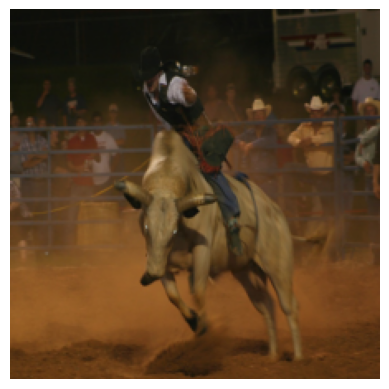

tensor([   2,   31,   27,    0, 6544,    0,   48,   18, 3370,  111,    0, 1993,
         621,   31, 2916,    3])
Caption :
<sos> a man <unk> being <unk> from the bull he <unk> riding during a rodeo <eos>


In [11]:
from src.utils import display_image
img, ids, cap_text = flickr_dataset[10366]
display_image(img)
print(ids)
print('Caption :')
print(vocab_builder.token_ids_to_caption(ids))

Defining dataloader for our dataset and also split dataset into train and test sets (80% train, 20% test)

In [12]:
train_size = int(0.8 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size
train_dataset, test_dataset = random_split(flickr_dataset, [train_size, test_size])

In [13]:
from src.batch_caption_collator import BatchCaptionCollator

pad_idx = vocab_builder.vocabulary['<pad>']
batch_size = 256
num_workers = 4
prefetch_factor = 4

collator = BatchCaptionCollator(pad_idx=pad_idx, batch_first=True)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)

test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=num_workers,
    prefetch_factor=prefetch_factor
)


Now it is time to define our model and hyperparameter:

In [14]:
vocab_size = len(vocab_builder.vocabulary)

emb_size = 300
attn_size = 256

drop_prob = 0.3

enc_hidden_size = 2048
dec_hidden_size = 512

learning_rate = 6e-4

In [15]:
from src.models.encoderdecoder import EncoderDecoder

model = EncoderDecoder(
    emb_size = emb_size,
    vocab_size = vocab_size,
    attn_size = attn_size,
    enc_hidden_size = enc_hidden_size,
    dec_hidden_size = dec_hidden_size,
    drop_prob = drop_prob,
    device = device
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Epoch: 1, Batch: 200, Training Loss: 3.90730


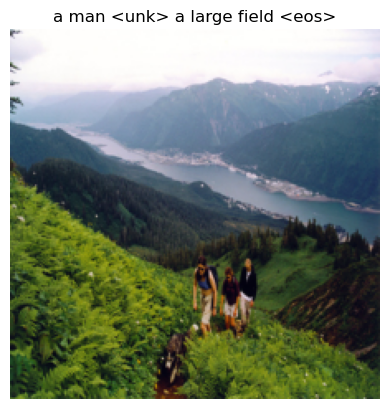

Epoch: 1, Batch: 400, Training Loss: 3.49684


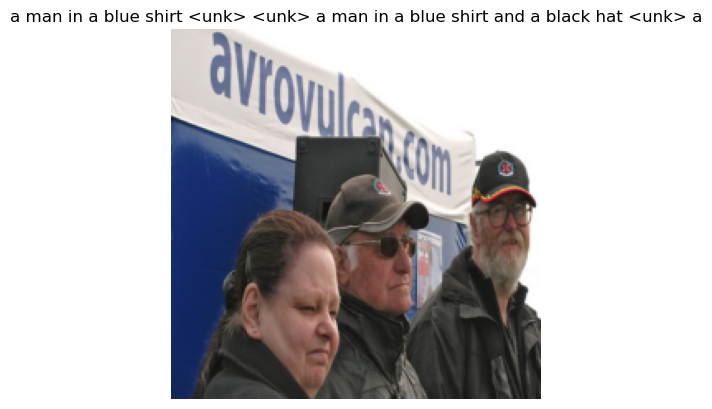

c:\Users\SH2\.conda\envs\image_captioning\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\SH2\.conda\envs\image_captioning\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\SH2\.conda\envs\image_captioning\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Epoch 1/10 - Training Loss: 3.9337, Validation Loss: 3.3105, BLEU Score: 0.0127
Model saved at saved_model\model_epoch_1.pth
Epoch: 2, Batch: 200, Training Loss: 3.20409


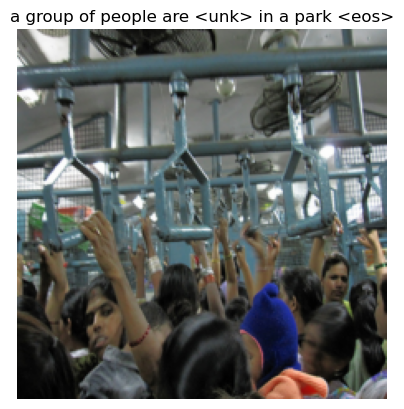

Epoch: 2, Batch: 400, Training Loss: 3.19160


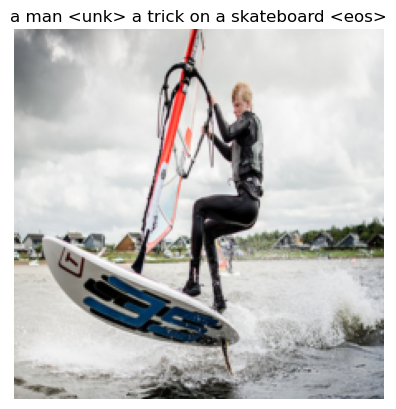

Epoch 2/10 - Training Loss: 3.1945, Validation Loss: 3.0393, BLEU Score: 0.0144
Model saved at saved_model\model_epoch_2.pth
Epoch: 3, Batch: 200, Training Loss: 2.95697


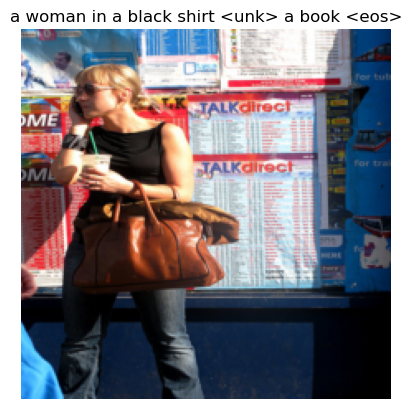

Epoch: 3, Batch: 400, Training Loss: 2.86201


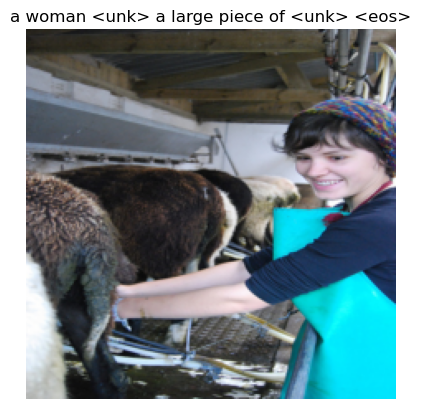

Epoch 3/10 - Training Loss: 2.9704, Validation Loss: 2.9070, BLEU Score: 0.0171
Model saved at saved_model\model_epoch_3.pth
Epoch: 4, Batch: 200, Training Loss: 2.86927


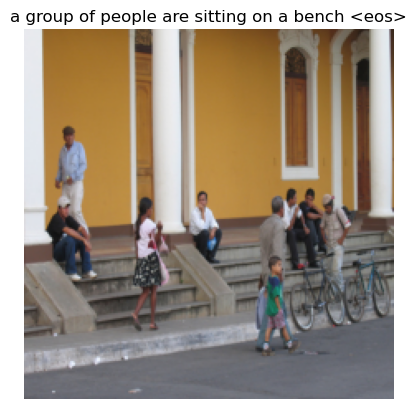

Epoch: 4, Batch: 400, Training Loss: 2.73785


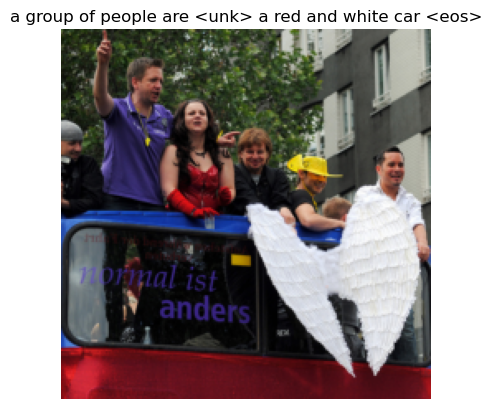

Epoch 4/10 - Training Loss: 2.8253, Validation Loss: 2.8258, BLEU Score: 0.0169
Model saved at saved_model\model_epoch_4.pth
Epoch: 5, Batch: 200, Training Loss: 2.69958


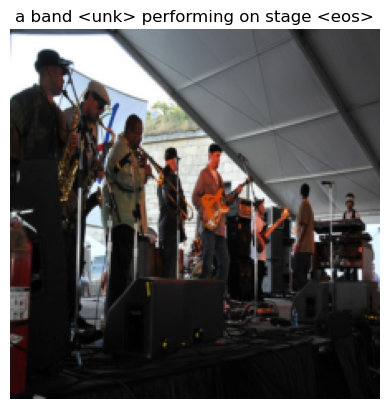

Epoch: 5, Batch: 400, Training Loss: 2.66282


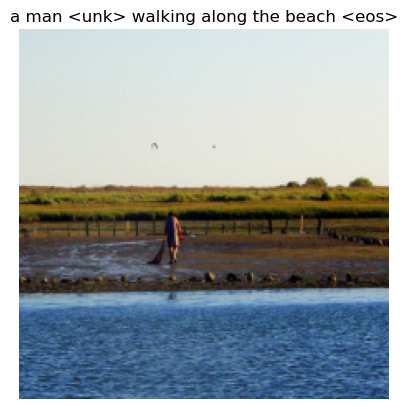

Epoch 5/10 - Training Loss: 2.7115, Validation Loss: 2.7709, BLEU Score: 0.0188
Model saved at saved_model\model_epoch_5.pth
Epoch: 6, Batch: 200, Training Loss: 2.54717


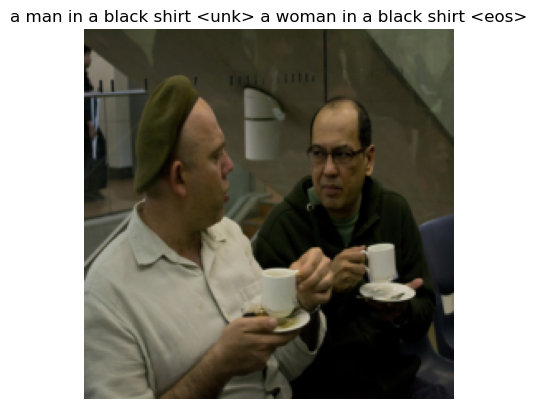

Epoch: 6, Batch: 400, Training Loss: 2.48461


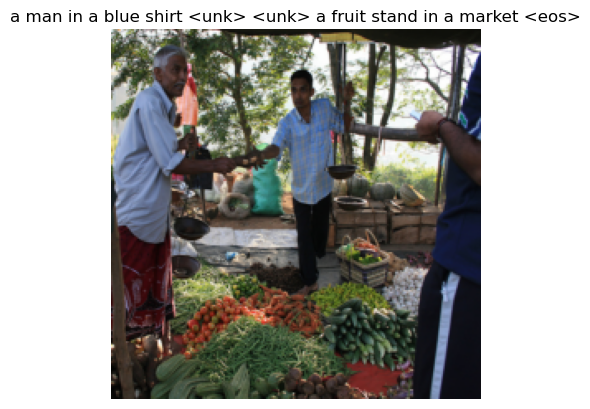

Epoch 6/10 - Training Loss: 2.6148, Validation Loss: 2.7311, BLEU Score: 0.0202
Model saved at saved_model\model_epoch_6.pth
Epoch: 7, Batch: 200, Training Loss: 2.48151


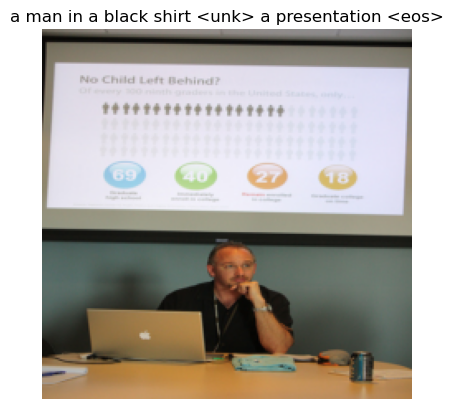

Epoch: 7, Batch: 400, Training Loss: 2.55528


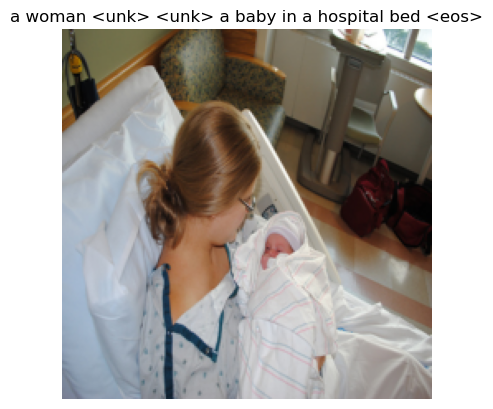

Epoch 7/10 - Training Loss: 2.5308, Validation Loss: 2.6997, BLEU Score: 0.0195
Model saved at saved_model\model_epoch_7.pth
Epoch: 8, Batch: 200, Training Loss: 2.47628


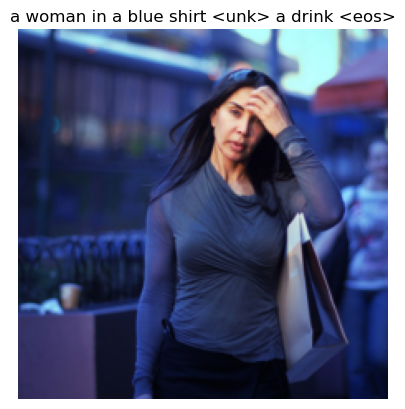

Epoch: 8, Batch: 400, Training Loss: 2.49288


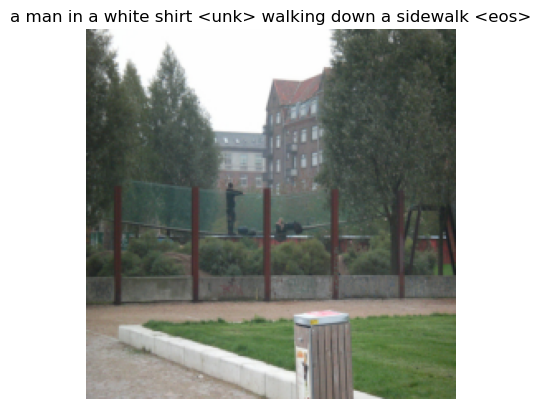

Epoch 8/10 - Training Loss: 2.4550, Validation Loss: 2.6788, BLEU Score: 0.0200
Model saved at saved_model\model_epoch_8.pth
Epoch: 9, Batch: 200, Training Loss: 2.34657


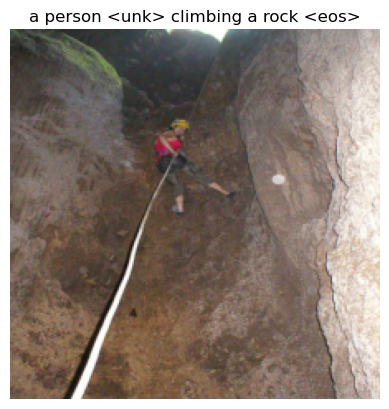

Epoch: 9, Batch: 400, Training Loss: 2.39348


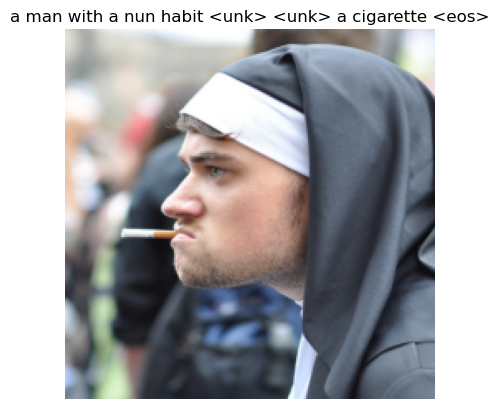

Epoch 9/10 - Training Loss: 2.3855, Validation Loss: 2.6623, BLEU Score: 0.0206
Model saved at saved_model\model_epoch_9.pth
Epoch: 10, Batch: 200, Training Loss: 2.35593


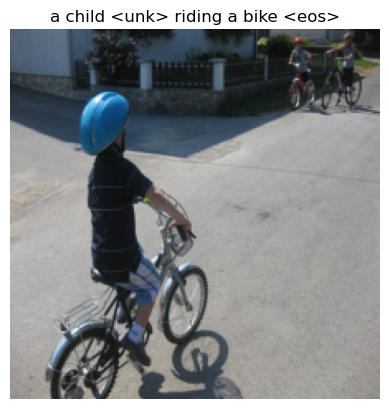

Epoch: 10, Batch: 400, Training Loss: 2.31570


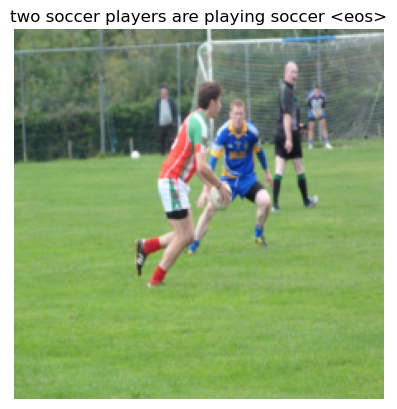

Epoch 10/10 - Training Loss: 2.3200, Validation Loss: 2.6545, BLEU Score: 0.0217
Model saved at saved_model\model_epoch_10.pth


In [16]:
save_dir = "saved_model"

num_epochs = 10
print_every = 200

train_losses = []
val_losses = []
bleu_scores = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0
    
    #Training loop
    for idx, (images, caption_token_ids, raw_captions) in enumerate(train_loader):
        images, caption_token_ids = images.to(device), caption_token_ids.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, attentions = model(images, caption_token_ids)
        targets = caption_token_ids[:, 1:]  # Shift captions by one token for targets

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()  # Backward pass
        optimizer.step()

        train_loss += loss.item()

        #Print training loss every `print_every` batches
        if (idx + 1) % print_every == 0:
            print(f'Epoch: {epoch}, Batch: {idx+1}, Training Loss: {loss.item():.5f}')

            #Show a sample generated caption
            model.eval()
            with torch.no_grad():
                img, _, _ = next(iter(train_loader))
                features = model.encoder(img[0:1].to(device))
                caps, attn_weights = model.decoder.generate_caption(features, vocab=flickr_dataset.vocabulary_builder.vocabulary)
                caption = ' '.join(caps)
                display_image(img[0], caption=caption)
                
            model.train()
    
    #Average training loss for epoch
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    #Validation loop
    model.eval()
    val_loss = 0
    epoch_bleu_score = 0
    with torch.no_grad():
        for val_images, val_captions_token_ids, val_captions_text in test_loader:
            val_images = val_images.to(device)
            val_captions_token_ids = val_captions_token_ids.to(device)

            #Forward pass
            val_outputs, _ = model(val_images, val_captions_token_ids)
            val_targets = val_captions_token_ids[:, 1:]  #Shift captions by 1 token for targets
            val_batch_loss = criterion(val_outputs.view(-1, vocab_size), val_targets.reshape(-1))
            val_loss += val_batch_loss.item()

            #BLEU Score Calculation
            for i in range(val_images.size(0)):
                features = model.encoder(val_images[i:i+1])
                generated_caption, _ = model.decoder.generate_caption(features, vocab=flickr_dataset.vocabulary_builder.vocabulary)

                reference_caption = [flickr_dataset.vocabulary_builder.spacy_tokenizer(val_captions_text[i])]

                #Compute BLEU score
                bleu_score = sentence_bleu(reference_caption, generated_caption)
                epoch_bleu_score += bleu_score

    #Average validation loss and BLEU score for epoch
    avg_val_loss = val_loss / len(test_loader)
    avg_bleu_score = epoch_bleu_score / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    bleu_scores.append(avg_bleu_score)

    print(f"Epoch {epoch}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, BLEU Score: {avg_bleu_score:.4f}")

    #Save model
    model_save_path = os.path.join(save_dir, f"model_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'bleu_score': avg_bleu_score
    }, model_save_path)
    
    print(f"Model saved at {model_save_path}")

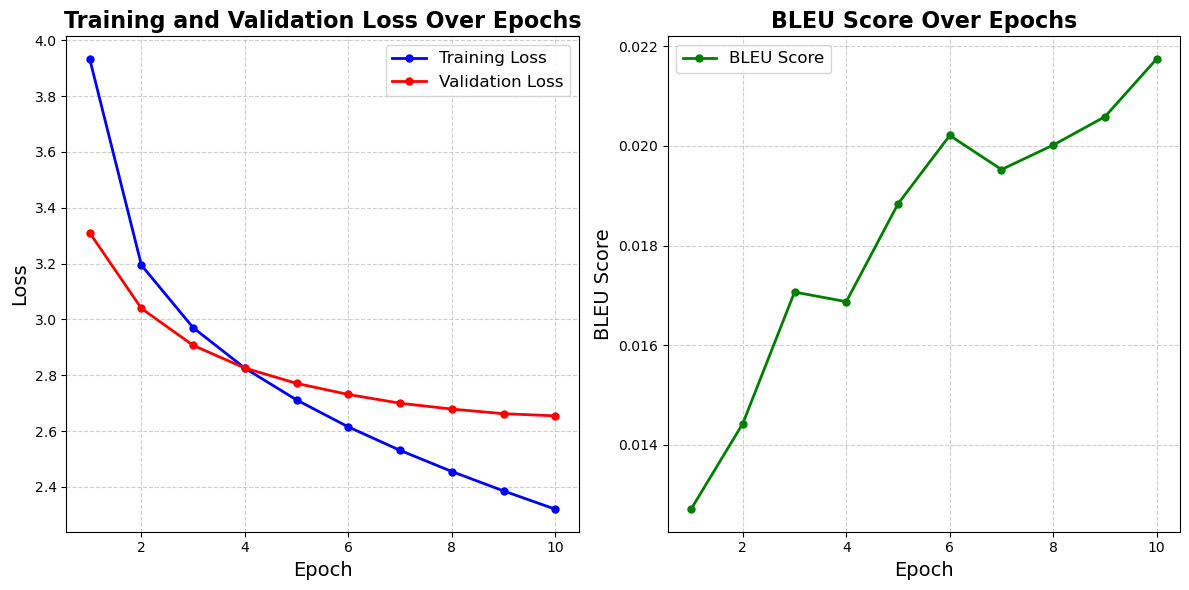

In [18]:
from src.utils import plot_metrics
plot_metrics(train_losses, val_losses, bleu_scores, save_dir)